# Table of Contents
 <p>

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as scipy
import scipy.stats as st
import sklearn.decomposition
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14


In [2]:
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
quant = pd.read_csv('../input/quantifications.csv')

In [3]:
frames = []
for root, dirs, files in os.walk("../kallisto"):
    if len(root.split(os.sep)) == 3:
        name = root.split(os.sep)[2]
        df = pd.read_csv(root + '/abundance.tsv', sep='\t')
        df['project'] = name
        df['strain'] = genmap[genmap.name == name].strain.values[0]
        df['genotype'] = genmap[genmap.name == name].genotype.values[0]
        df['batch'] = genmap[genmap.name == name].batch.values[0]
        df.strain = df.strain.str.replace('b_', '')
        df.strain = df.strain.str.replace('a_', '')
        frames += [df]
tpm = pd.concat(frames)

In [4]:
strains = ['ps4187', 'ps4087', 'ps4176', 'mt21245', 'mt4866', 'n2']

In [5]:
tpm = tpm[(tpm.strain.isin(strains)) & (tpm.batch == 'e')]
tidy = quant[quant.strain.isin(strains)].copy()

In [6]:
tpm.genotype = tpm.genotype.str.replace('b_', '')
tpm.genotype = tpm.genotype.str.replace('a_', '')
tpm.genotype = tpm.genotype.str.replace('_', '-')

In [7]:
tidy.genotype.unique()

array(['dpy22-a1', 'dpy22-a2', 'dpy22-a1a2het', 'let60-gf', 'let60-lf'], dtype=object)

In [8]:
tidy = tidy.dropna(subset=['b'])
grouped = tidy.groupby('target_id')

n = len(tidy.strain.unique())
names = []
for name, group in grouped:
    if len(group) == n:
        names += [name]

In [9]:
grouped = tpm.groupby(['project', 'batch'])

bvals = np.array([])
glabels = []
blabels = []
nlabels = []
for code, group in grouped:
    ind = group.target_id.isin(names)    
    bs = group[ind].est_counts.values

    # standardize bs
    if any(bs < 0):
        raise ValueError('uhoh')
    bs = (bs - bs.mean())/(bs.std())
    if len(bvals) == 0:
        bvals = bs
    else:
        bvals = np.vstack((bvals, bs))

    # make a label array
    glabels +=  [group.genotype.values[0]]
    blabels +=  [group.batch.values[0]]
    nlabels +=  [group.project.values[0]]

Variance percent explained
 [ 0.38443332  0.2480378   0.10233208  0.07746166  0.05391506]


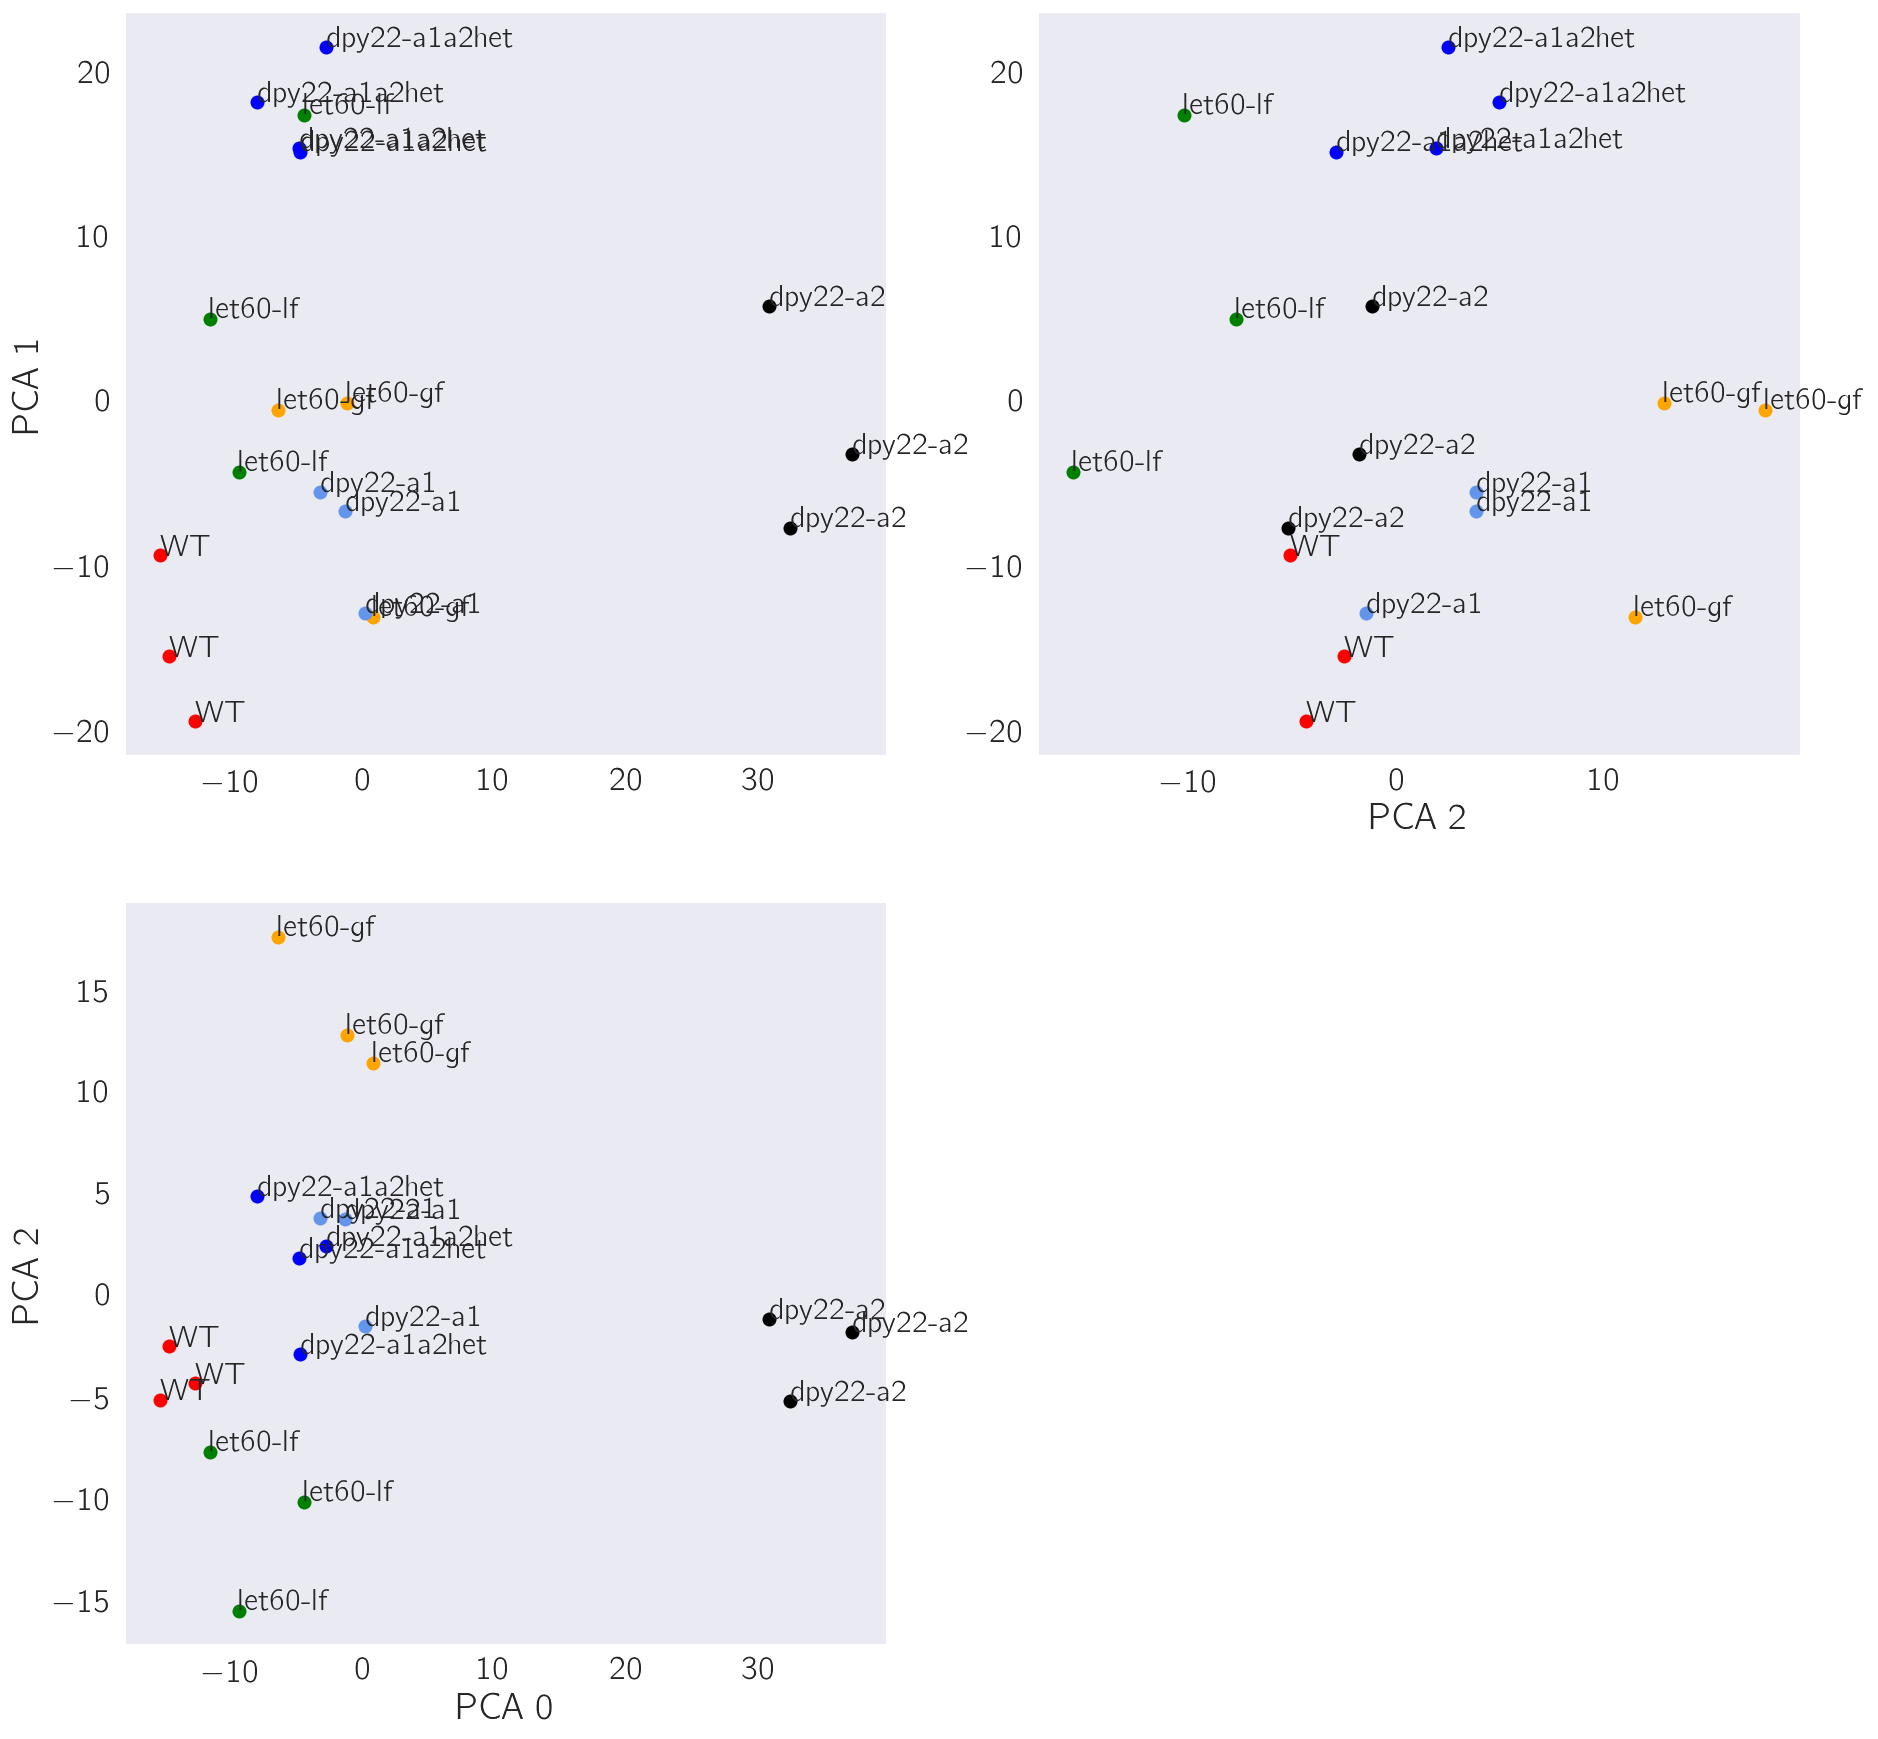

In [10]:
# initialize the PCA object and fit to the b-values
sklearn_pca = sklearn.decomposition.PCA(n_components=5).fit(bvals)

print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)


coords = sklearn_pca.fit(bvals).transform(bvals)

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628', 'k']
shapes = ['D', 'D', 'v', '8', 'D', 'v', 'o']
offsetx, offsety = 0, 0

# go through each pair of points and plot them:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i, array in enumerate(coords):
    if glabels[i] == 'WT':
        color = 'red'
    elif glabels[i] == 'dpy22-a1a2het':
        color = 'blue'
    elif glabels[i] == 'dpy22-a1':
        color = 'cornflowerblue'
    elif glabels[i] == 'let60-gf':
        color = 'orange'
    elif glabels[i] == 'let60-lf':
        color = 'green'
    else:
        color = 'black'
    alpha=1
    n = glabels[i]
    ax[0, 0].plot(array[0], array[1], 'o', ms=7, color=color, alpha=alpha)
#     ax[0, 0].annotate(blabels[i], array[0:2]+2, fontsize=20)
    ax[0, 0].annotate(n, array[0:2]+[offsetx, offsety], fontsize=15)
    ax[0, 0].set_ylabel('PCA {0}'.format(1))

    ax[1, 0].plot(array[0], array[2], 'o', ms=7, color=color, alpha=alpha)
    ax[1, 0].annotate(n, (array[0]+offsetx, array[2]+offsety), fontsize=15)
    ax[1, 0].set_xlabel('PCA {0}'.format(0))
    ax[1, 0].set_ylabel('PCA {0}'.format(2))

    ax[0, 1].plot(array[2], array[1], 'o', ms=7, color=color, alpha=alpha)
    ax[0, 1].annotate(n, (array[2]+offsetx, array[1]+offsety), fontsize=15)
    ax[0, 1].set_xlabel('PCA {0}'.format(2))

ax[1,1].axis('off')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')

plt.savefig('../output/tpm_pca.svg', bbox_inches='tight')

In [11]:
grouped = tpm.groupby(['strain', 'batch'])
spearman_corrs = []
strain_list = []
for code, group in grouped:
    s = code[0]
    projects = group.project.unique()
    spearman = []
    for i, p1 in enumerate(projects):
        tpm1 = group[group.project == p1].est_counts.values
        for j, p2 in enumerate(projects[i+1:]):
            tpm2 = group[group.project == p2].est_counts.values
            spearman_corrs += [st.spearmanr(tpm1, tpm2).correlation]
            if s != 'n2':
                strain_list += [s.replace('_', '-')]
            else:
                strain_list += [s+ '-' + code[1]]

In [12]:
spearman = pd.DataFrame(np.vstack((spearman_corrs,strain_list)).T, columns=['spearmanr', 'genotype'])

In [13]:
spearman.spearmanr = pd.to_numeric(spearman.spearmanr)

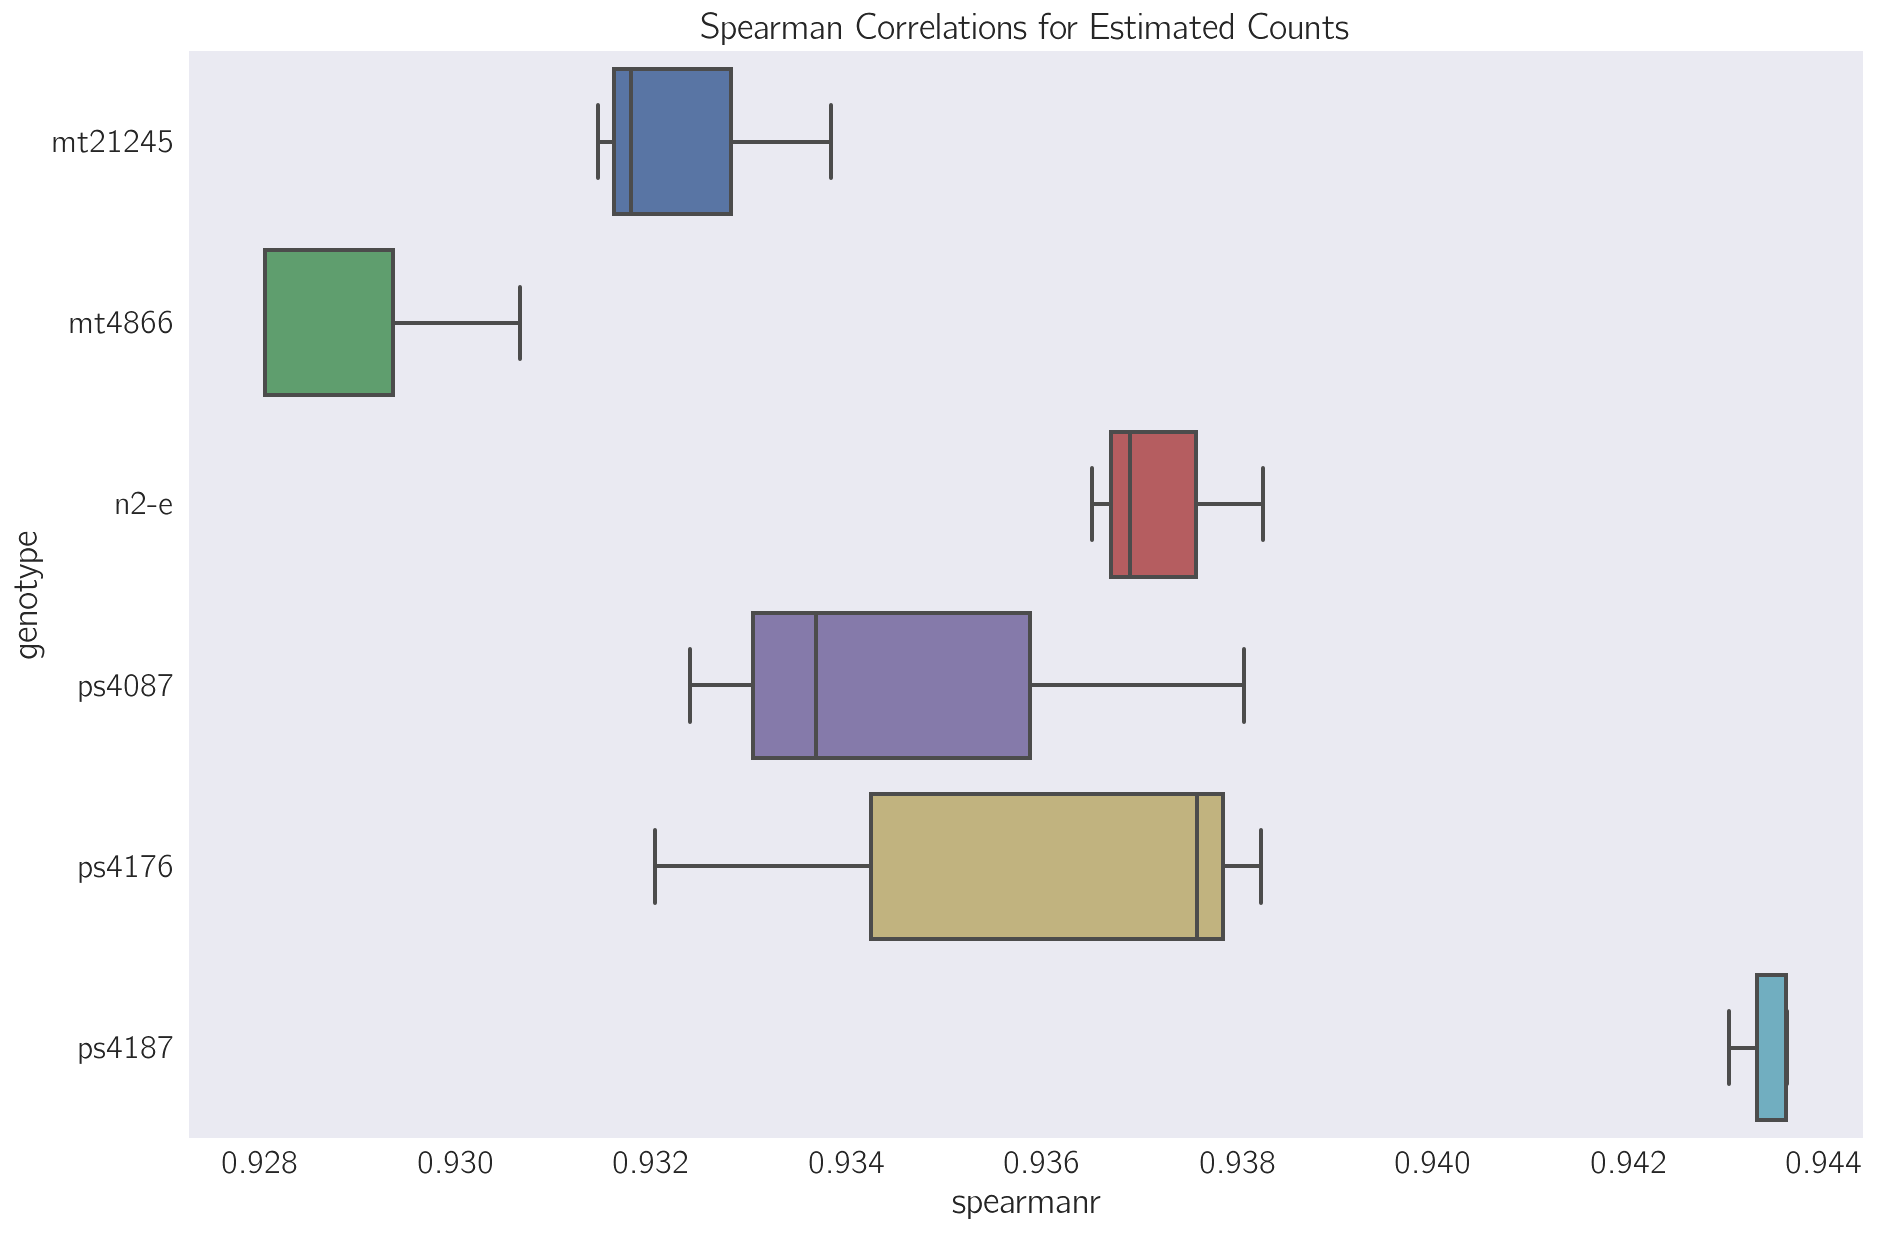

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y='genotype', x='spearmanr', data=spearman, ax=ax)
plt.title('Spearman Correlations for Estimated Counts')
plt.savefig('../output/spearman_correlations.pdf', bbox_inches='tight')

In [16]:
grouped = tpm.groupby('project')

matrix = np.zeros((len(tpm.project.unique()), len(tpm.target_id.unique())))
i = 0
glabels = np.array([])
for name, group in grouped:
    matrix[i, :] = group.est_counts.values
    glabels = np.append(glabels, group.genotype.unique())
    i += 1

In [17]:
from sklearn.decomposition import NMF

In [18]:
model = NMF(n_components=5, init='random', random_state=0)

In [19]:
W = model.fit(matrix).transform(matrix)
H = model.components_.T

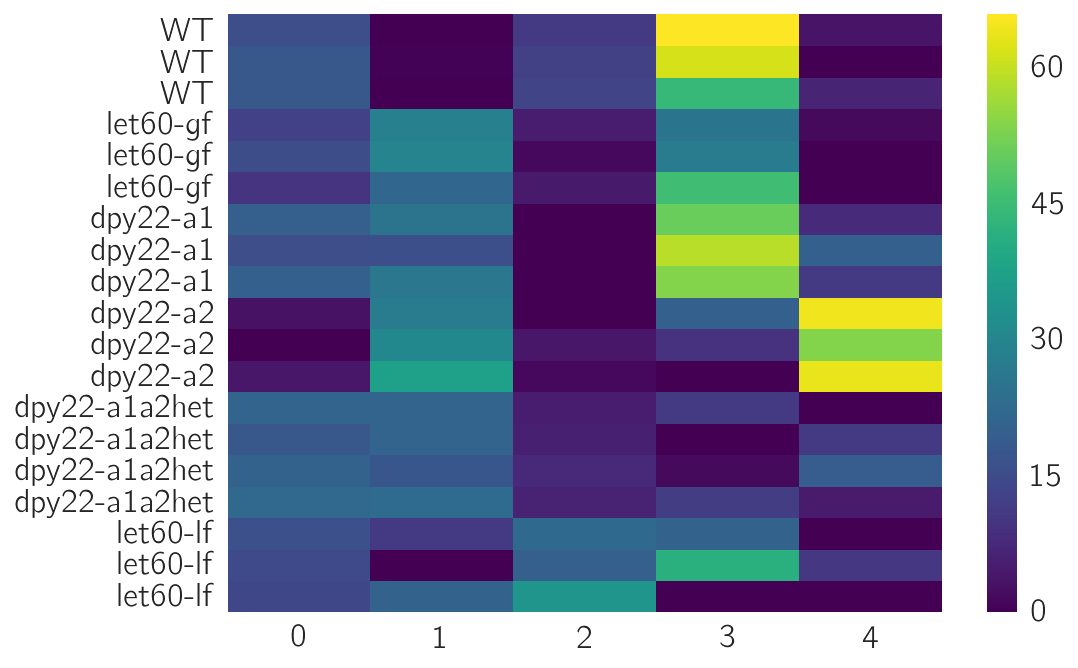

In [20]:
sns.heatmap(W, cmap='viridis')
plt.gca().set_yticklabels(glabels[::-1])